# Breast cancer data set

In [1]:
import pandas as pd

breast_cancer_data = pd.read_csv('http://www.randalolson.com/data/benchmarks/breast-cancer-wisconsin.csv.gz',
                                 sep='\t',
                                 compression='gzip')
breast_cancer_data.head()

,class,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Compute the cross-validation scores

Here, the scores are accuracy on the data set.

In [2]:
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier

cross_val_score(RandomForestClassifier(n_estimators=100, n_jobs=-1),
                breast_cancer_data.drop('class', axis=1).values,
                breast_cancer_data.loc[:, 'class'].values, cv=10)

array([ 0.98275862,  0.89655172,  0.92982456,  0.96491228,  1.        ,
        0.98245614,  0.96491228,  0.98214286,  0.94642857,  1.        ])

## Visualize the predictions vs. actual status

Each dot corresponds to one prediction.

### Training data

/Users/randal_olson/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


''

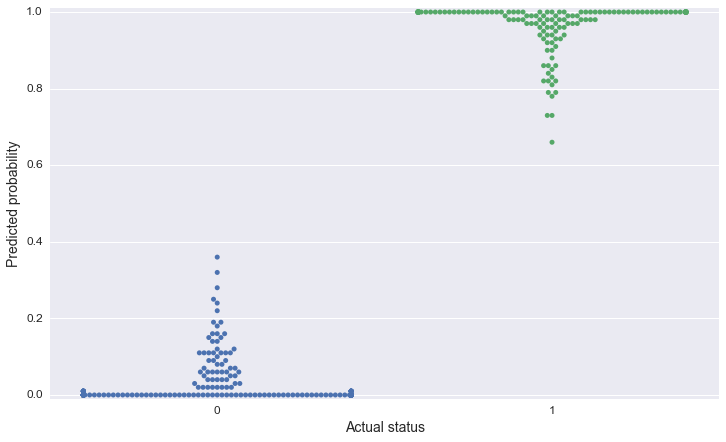

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split

breast_cancer_data = pd.read_csv('http://www.randalolson.com/data/benchmarks/breast-cancer-wisconsin.csv.gz',
                                 sep='\t',
                                 compression='gzip')

X_train, X_test, y_train, y_test = train_test_split(breast_cancer_data.drop('class', axis=1).values,
                                                    breast_cancer_data['class'].values,
                                                    stratify=breast_cancer_data['class'].values,
                                                    train_size=0.75, test_size=0.25)

clf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
clf.fit(X_train, y_train)

plt.figure(figsize=(12, 7))
sb.swarmplot(y_train, clf.predict(X_train))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Actual status', fontsize=14)
plt.ylabel('Predicted probability', fontsize=14)
plt.ylim(-0.01, 1.01)
;

### Testing data

''

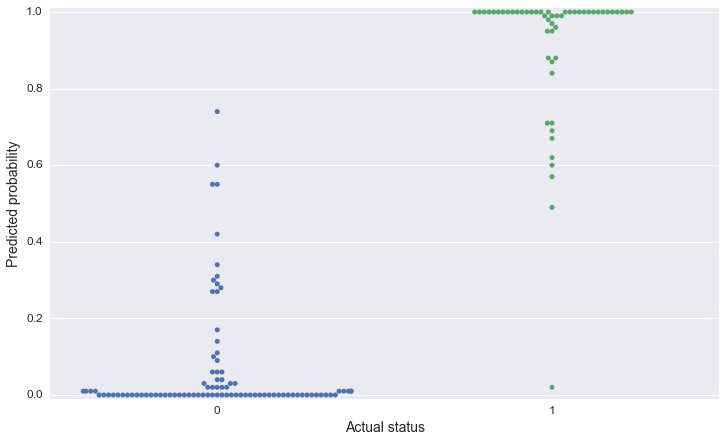

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split

breast_cancer_data = pd.read_csv('http://www.randalolson.com/data/benchmarks/breast-cancer-wisconsin.csv.gz',
                                 sep='\t',
                                 compression='gzip')

X_train, X_test, y_train, y_test = train_test_split(breast_cancer_data.drop('class', axis=1).values,
                                                    breast_cancer_data['class'].values,
                                                    stratify=breast_cancer_data['class'].values,
                                                    train_size=0.75, test_size=0.25)

clf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
clf.fit(X_train, y_train)

plt.figure(figsize=(12, 7))
sb.swarmplot(y_test, clf.predict(X_test))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Actual status', fontsize=14)
plt.ylabel('Predicted probability', fontsize=14)
plt.ylim(-0.01, 1.01)
;

# Spambase data set

In [5]:
import pandas as pd

spambase_data = pd.read_csv('http://www.randalolson.com/data/benchmarks/spambase.csv.gz',
                            sep='\t',
                            compression='gzip')
spambase_data.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


## Compute the cross-validation scores

Here, the scores are accuracy on the data set.

In [6]:
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier

cross_val_score(RandomForestClassifier(n_estimators=100, n_jobs=-1),
                spambase_data.drop('class', axis=1).values,
                spambase_data.loc[:, 'class'].values,
                cv=10)

array([ 0.95227766,  0.95227766,  0.93709328,  0.95      ,  0.95217391,
        0.96304348,  0.97173913,  0.97173913,  0.89542484,  0.8583878 ])

## Visualize the predictions vs. actual status

Each dot corresponds to one prediction.

### Training data

''

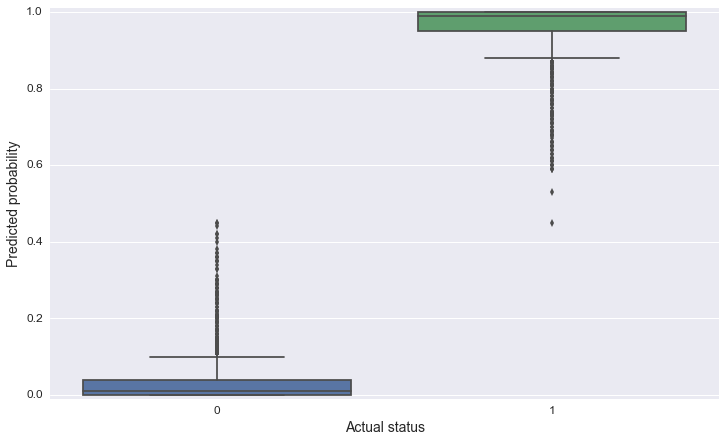

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split

spambase_data = pd.read_csv('http://www.randalolson.com/data/benchmarks/spambase.csv.gz',
                            sep='\t',
                            compression='gzip')

X_train, X_test, y_train, y_test = train_test_split(spambase_data.drop('class', axis=1).values,
                                                    spambase_data['class'].values,
                                                    stratify=spambase_data['class'].values,
                                                    train_size=0.75, test_size=0.25)

clf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
clf.fit(X_train, y_train)

plt.figure(figsize=(12, 7))
sb.boxplot(y_train, clf.predict(X_train))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Actual status', fontsize=14)
plt.ylabel('Predicted probability', fontsize=14)
plt.ylim(-0.01, 1.01)
;

### Testing data

''

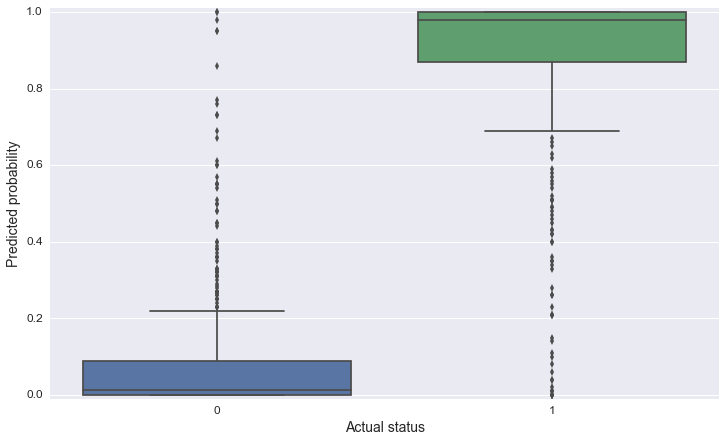

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split

spambase_data = pd.read_csv('http://www.randalolson.com/data/benchmarks/spambase.csv.gz',
                            sep='\t',
                            compression='gzip')

X_train, X_test, y_train, y_test = train_test_split(spambase_data.drop('class', axis=1).values,
                                                    spambase_data['class'].values,
                                                    stratify=spambase_data['class'].values,
                                                    train_size=0.75, test_size=0.25)

clf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
clf.fit(X_train, y_train)

plt.figure(figsize=(12, 7))
sb.boxplot(y_test, clf.predict(X_test))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Actual status', fontsize=14)
plt.ylabel('Predicted probability', fontsize=14)
plt.ylim(-0.01, 1.01)
;